In [1]:
%load_ext jupyter_black
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

backend = "pyro"

if backend == "pyro":
    import torch

    tensor = torch

else:
    import jax.numpy as jnp

    tensor = jnp

A brief tutorial for simulating behaviour in a multi armed bandit task and using simulated response to invert the model and infer model parameters for individual agents/subjects

In [2]:
import numpy as np
from local import MABTask, UCBAgent
from pybefit.agents import transform

if backend == "pyro":
    from pybefit.inference import PyroGuide as Guide
    from pybefit.inference import PyroModel as Model
    from pyro.infer import Predictive
    from pybefit.inference.pyro.likelihoods import befit_likelihood as likelihood
    from pybefit.inference.methods import (
        default_dict_pyro_svi,
        format_posterior_samples,
        get_log_evidence_per_subject,
    )
else:
    from pybefit.inference import NumpyroGuide as Guide
    from pybefit.inference import NumpyroModel as Model
    from numpyro.infer import Predictive
    from pybefit.inference.numpyro.likelihoods import befit_likelihood as likelihood

from pybefit.inference import NormalGamma as Prior
from pybefit.inference import NormalGammaPosterior as Posterior

from pybefit.inference import run_nuts, run_svi

We start by first generating a time sequence of possible choice outcomes for the task and pack this inside the "MABTask" class.

In [12]:
blocks = 20
trials = 10
num_arms = 3
num_agents = 200

# create task environment
probs = np.random.dirichlet(np.ones(num_arms), size=(num_agents,))
outcomes = tensor.ones(1) * np.random.binomial(
    1, probs, size=(blocks, trials, num_agents, num_arms)
).astype(np.float32)

print(outcomes.dtype, outcomes.shape)

mab_task = MABTask(outcomes)

# create agent to recover number of parameters
ucb_agent = UCBAgent(runs=num_agents, blocks=blocks, trials=trials, num_arms=num_arms)
num_params = ucb_agent.num_params

# set task and agent option dictionaries
opts_task = {
    "task": mab_task,
    "blocks": blocks,
    "trials": trials,
    "num_agents": num_agents,
}

# set kwargs for transform which are passed to the agent constractor
opts_transform = {"blocks": blocks, "trials": trials, "num_arms": num_arms}

# set options for prior, transform and likelihood
opts_model = {"prior": {}, "transform": opts_transform, "likelihood": opts_task}

# define a transform for mapping unconstrained parameters 'z' to the corresponding agent class
transform_ucb = lambda z, **kwargs: transform(z, UCBAgent, **kwargs)

prior = Prior(num_params, num_agents, init_scale=0.1, backend=backend)
gen_model = Model(prior, transform_ucb, likelihood, opts=opts_model)
posterior = Guide(Posterior(num_params, num_agents, backend=backend))

torch.float32 torch.Size([20, 10, 200, 3])


Lets generate a sample from the generative model. This will sample from prior distribution some parameter values for each agent, and generate agent responses over the course of experiment, given the task environment.

In [13]:
pred = Predictive(gen_model, num_samples=1)
prior_predictive_sample = pred()

Lets plot behavioural responses

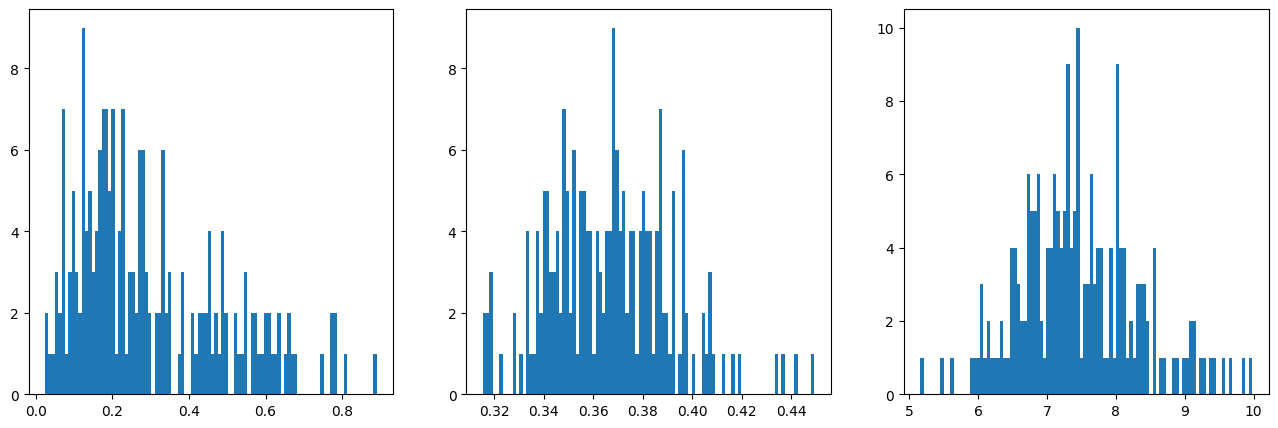

In [14]:
ucb_agent.set_parameters(prior_predictive_sample["z"][0])

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].hist(ucb_agent.lr, bins=100)
axes[1].hist(ucb_agent.c, bins=100)
axes[2].hist(ucb_agent.beta, bins=100);

In [15]:
measurments = {
    "offers": None,
    "outcomes": prior_predictive_sample["outcomes"][0],
    "mask": None,
    "responses": prior_predictive_sample["responses"][0],
}

num_samples = 1000

# perform inference using stochastic variational inference
opts_svi = default_dict_pyro_svi
opts_svi.update({"sample_kwargs": {"num_samples": num_samples}, "iter_steps": 5_000})

samples, svi, results = run_svi(gen_model, posterior, measurments, opts=opts_svi)

  0%|          | 0/5000 [00:00<?, ?it/s]

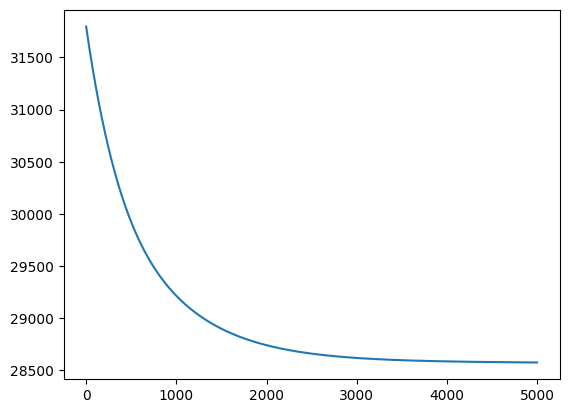

In [16]:
plt.plot(results["loss"])